In [5]:
from transformers import BertTokenizer, TFBertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
from sklearn.model_selection import train_test_split
import torch

# Load data
df = pd.read_csv("../datasets/combined/combined_dataset_200samples_50-50split.csv")

# Preprocess labels
df['label'] = df['label'].map({'real': 1, 'fake': 0})

# Optional: concatenate header + article
df['text'] = df['header'] + " " + df['article']

# Train/test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)

In [6]:
import tensorflow as tf

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')

# Tokenize data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors='tf')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512, return_tensors='tf')

# Convert labels to tf.constant
train_labels_tf = tf.constant(train_labels)
val_labels_tf = tf.constant(val_labels)

# Build tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels_tf
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels_tf
))

# Optional: batch the datasets
train_dataset = train_dataset.shuffle(100).batch(8)
val_dataset = val_dataset.batch(8)

In [7]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 20
Validation dataset size: 5


In [9]:
import tensorflow as tf

model = TFBertForSequenceClassification.from_pretrained('bert-base-german-cased', num_labels=2)

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf._metrics.SparseCategoricalAccuracy(),
)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1,
    batch_size=8
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


20/20 [==============================] - 293s 14s/step - loss: 0.5915 - sparse_categorical_accuracy: 0.6625 - val_loss: 0.4307 - val_sparse_categorical_accuracy: 0.8000


5/5 [==============================] - 21s 4s/step
              precision    recall  f1-score   support

        fake       0.81      0.81      0.81        21
        real       0.79      0.79      0.79        19

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40



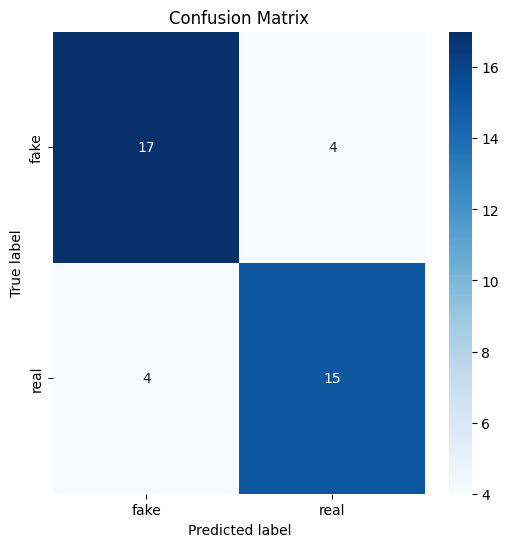

In [13]:
# Classification report (Precision, Recall, F1, Accuracy)
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on val set
val_pred_logits = model.predict(val_dataset).logits
val_pred = np.argmax(val_pred_logits, axis=1)

# True labels
val_true = val_labels_tf.numpy()

# Print full classification report
report = classification_report(val_true, val_pred, target_names=['fake', 'real'])
print(report)

# Confusion matrix
cm = confusion_matrix(val_true, val_pred)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


In [14]:
from dotenv import load_dotenv
import os

load_dotenv()

access_token = os.getenv('ACCESS_TOKEN_HUGGING_FACE')

model.push_to_hub("krisschaaf/bert_german_fake_news_1", private=True, token=access_token)

tf_model.h5: 100%|██████████| 437M/437M [02:14<00:00, 3.25MB/s] 


In [16]:
model.summary()

Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109081344 
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109082882 (416.12 MB)
Trainable params: 109082882 (416.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
tfBertMainLayer = model.bert
tfBertMainLayerConfig = tfBertMainLayer.config
tfBertMainLayerConfig


BertConfig {
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}